In [1]:
# ==== Define functions (run once) ====
import os, re, pandas as pd, numpy as np, matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = [
    'SimHei', 'Microsoft YaHei', 'HanaMinA', 'Source Han Sans CN',
    'Noto Sans CJK SC', 'WenQuanYi Zen Hei', 'PingFang SC', 'sans-serif'
]
plt.rcParams['axes.unicode_minus'] = False


def _find_sheet_like(xls: pd.ExcelFile, target_exact: str, fallback_contains: str) -> str:
    """
    Locate a worksheet in an Excel file by exact name or fallback keyword.

    Parameters:
        xls: Opened Excel file object.
        target_exact: Preferred sheet name (exact match).
        fallback_contains: Substring to search if exact match fails.

    Returns:
        Name of the matched sheet.
    """
    sheets = [s.strip() for s in xls.sheet_names]
    if target_exact in sheets:
        return target_exact
    # Normalize by removing whitespace for flexible matching
    norm_map = {re.sub(r"\s+", "", s): s for s in sheets}
    key = re.sub(r"\s+", "", target_exact)
    if key in norm_map:
        return norm_map[key]
    # Fallback: find first sheet containing the keyword
    for s in sheets:
        if fallback_contains in s:
            return s
    return sheets[0]  # Ultimate fallback: first sheet


def _get_offset_series(df: pd.DataFrame) -> pd.Series:
    """
    Extract the 'Offset' column from a DataFrame, handling naming variations.

    Tries to find a column named 'Offset' (case-insensitive, whitespace-tolerant).
    If not found and at least two columns exist, uses the second column.

    Returns:
        A numeric Series of offset values with NaNs removed.
    """
    col = None
    for c in df.columns:
        if str(c).strip().lower() == "offset":
            col = c
            break
    if col is None:
        if df.shape[1] >= 2:
            col = df.columns[1]
        else:
            raise ValueError("The table lacks an 'Offset' column, and there are insufficient columns to fall back to the second one.")
    return pd.to_numeric(df[col], errors="coerce").dropna().astype(float)


def _maybe_sort_by_bufid(df: pd.DataFrame) -> pd.DataFrame:
    """
    Sort DataFrame by 'BufId' column if it exists (case-insensitive match).

    Uses stable sort ('mergesort') to preserve order among equal keys.
    """
    for c in df.columns:
        if str(c).strip().lower() == "bufid":
            return df.sort_values(by=c, kind="mergesort")
    return df


def plot_for_file(xlsx_path: str, out_dir: str):
    """
    Generate two plots for a single Excel file: boxplot + heatmap.

    Saves images to out_dir and returns list of saved file paths.

    Plots:
      1. Boxplot of Offset distribution from "Full Valid Data" sheet.
      2. Heatmap of Offsets for small BufIds from "Small BufId Data" sheet.
    """
    os.makedirs(out_dir, exist_ok=True)
    xls = pd.ExcelFile(xlsx_path)
    task_name = os.path.splitext(os.path.basename(xlsx_path))[0]
    m = re.match(r"(.+?)_memory_analysis", task_name)
    task_name = m.group(1) if m else task_name

    # 1) Boxplot: Full valid data
    sheet_valid = _find_sheet_like(xls, "完整有效数据", "完整")
    df_valid = pd.read_excel(xlsx_path, sheet_name=sheet_valid)
    offsets_valid = _get_offset_series(df_valid)

    plt.figure(figsize=(5, 4), dpi=160)
    plt.boxplot(offsets_valid.values, vert=True, widths=0.4, showfliers=True)
    plt.title(f"{task_name} — Offset Distribution Boxplot", fontsize=10)
    plt.ylabel("Offset", fontsize=9)
    plt.grid(True, axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    out_box = os.path.join(out_dir, f"{task_name}_offset_boxplot.png")
    plt.savefig(out_box, bbox_inches="tight")
    plt.close()

    # 2) Heatmap: Small BufId data
    sheet_small = _find_sheet_like(xls, "小 BufId 数据", "小")
    df_small = pd.read_excel(xlsx_path, sheet_name=sheet_small)
    df_small = _maybe_sort_by_bufid(df_small)
    offsets_small = _get_offset_series(df_small)
    arr = offsets_small.values.reshape(-1, 1)

    plt.figure(figsize=(6, max(2, min(10, len(offsets_small) * 0.03))), dpi=160)
    im = plt.imshow(arr, aspect="auto", cmap="RdBu_r", interpolation="nearest")
    plt.title(f"{task_name} — Offset Heatmap for Small BufIds", fontsize=10)
    plt.xlabel("Offset Color Scale", fontsize=9)
    n = len(offsets_small)
    if n > 1:
        step = max(1, n // 20)
        plt.yticks(list(range(0, n, step)), fontsize=7)
    plt.xticks([])
    cbar = plt.colorbar(im, fraction=0.035, pad=0.04)
    cbar.set_label("Offset", fontsize=9)
    plt.tight_layout()
    out_heat = os.path.join(out_dir, f"{task_name}_offset_heatmap.png")
    plt.savefig(out_heat, bbox_inches="tight")
    plt.close()

    return [out_box, out_heat]

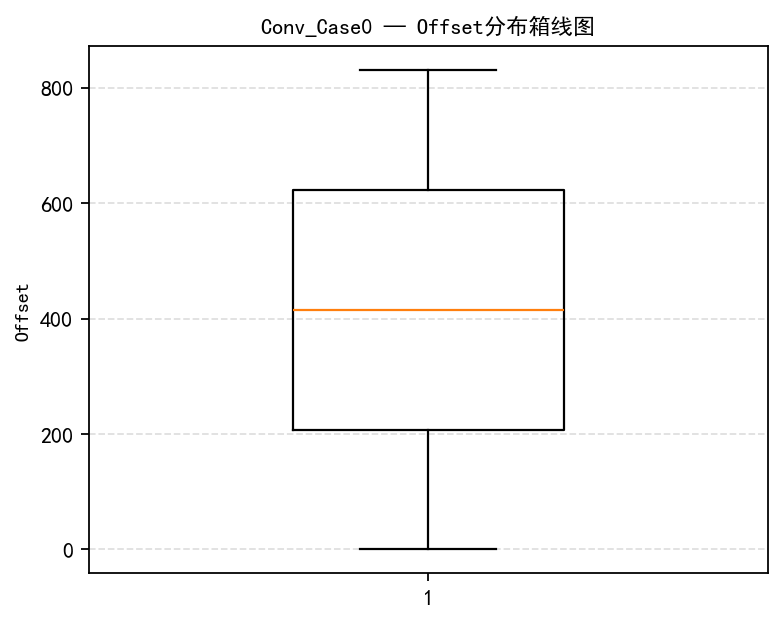

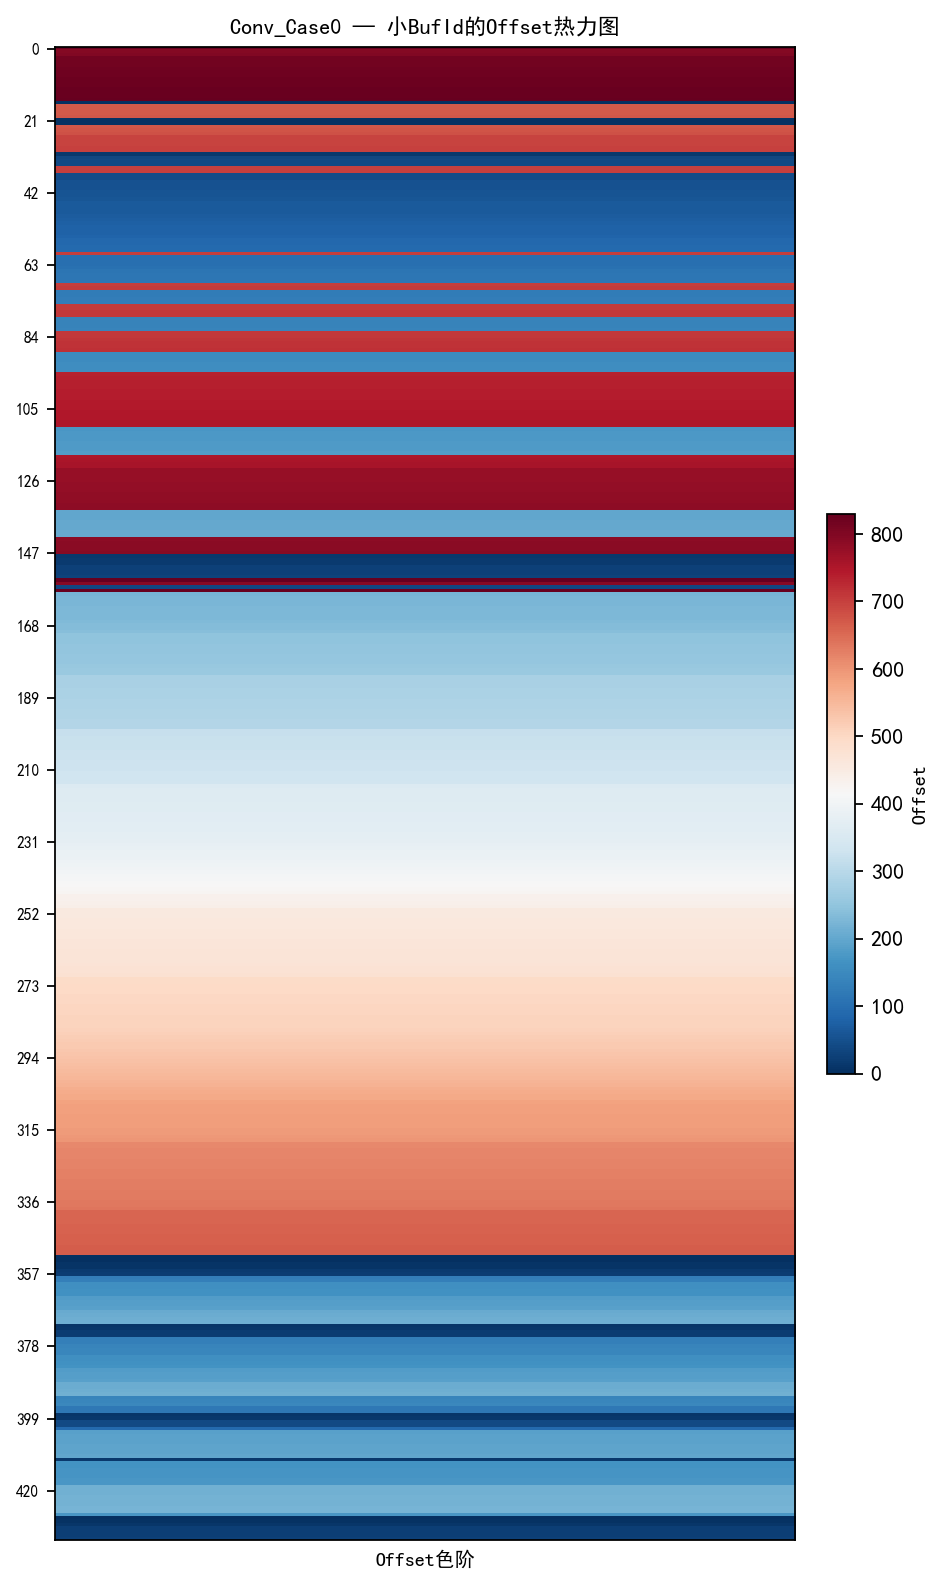

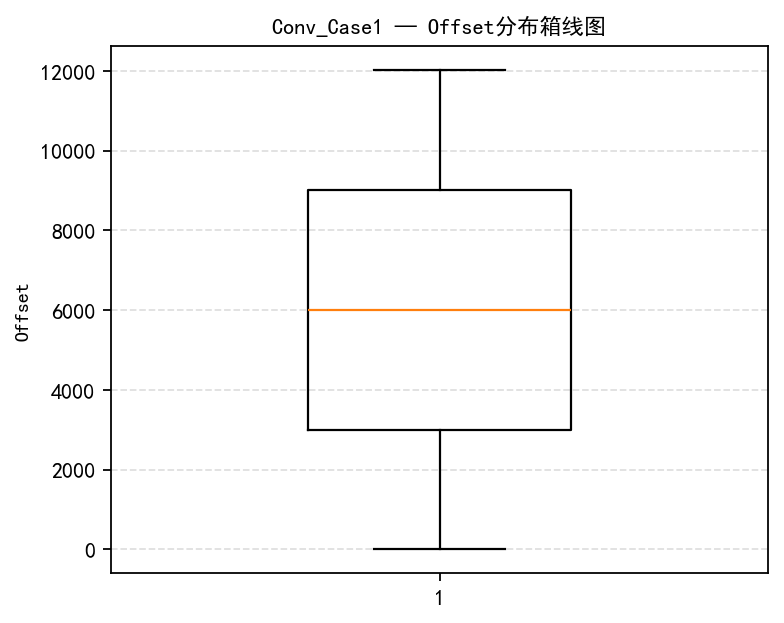

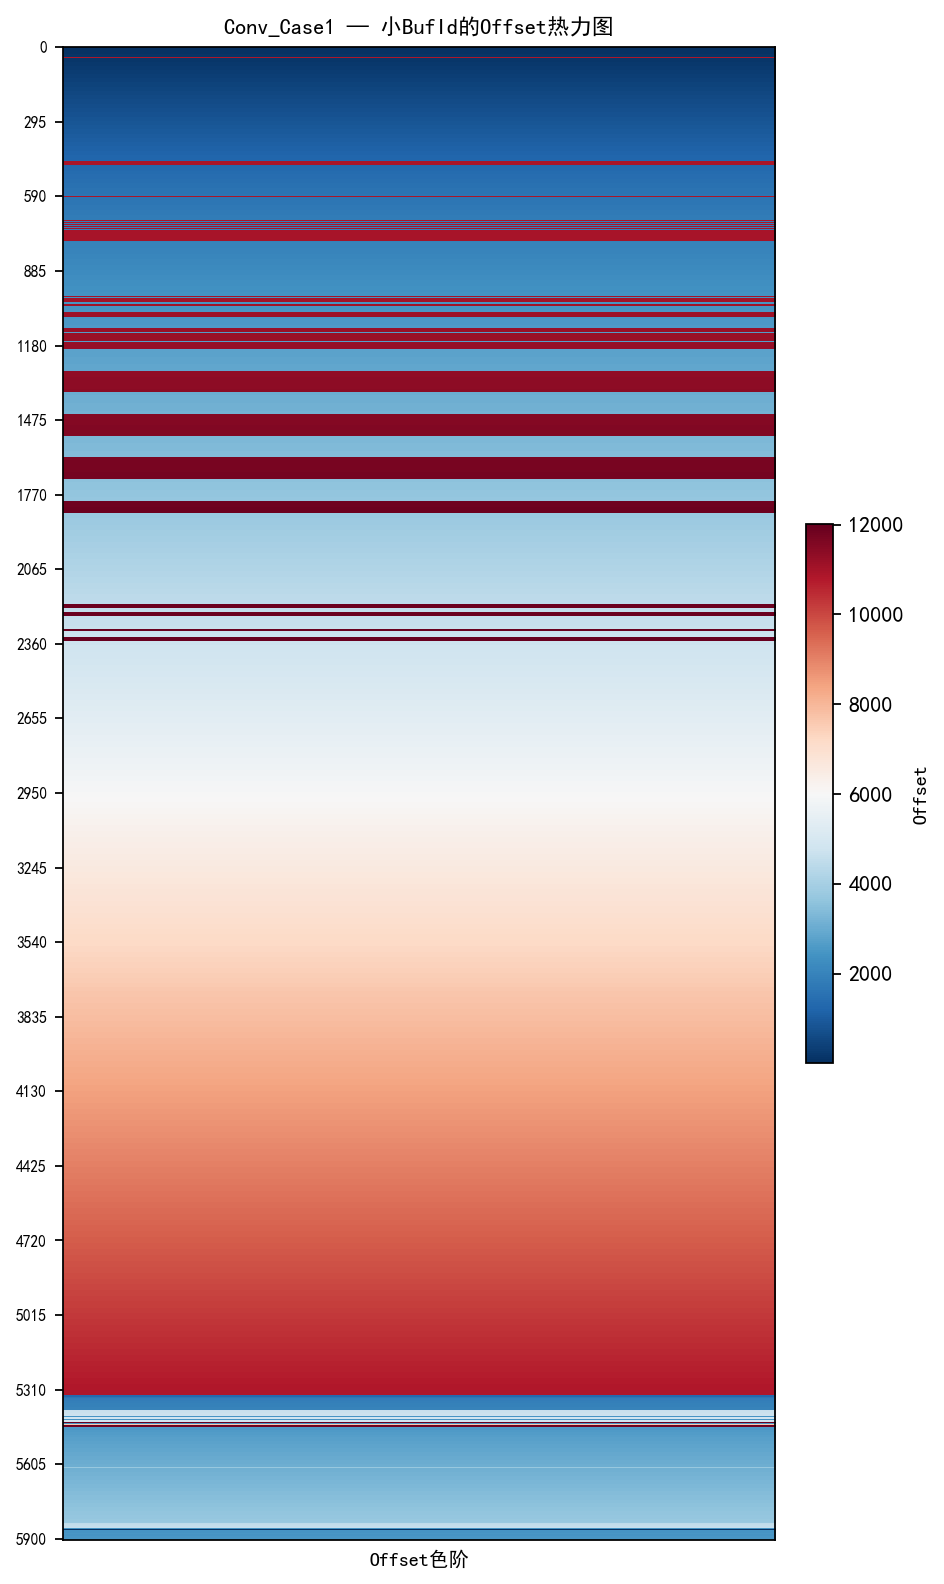

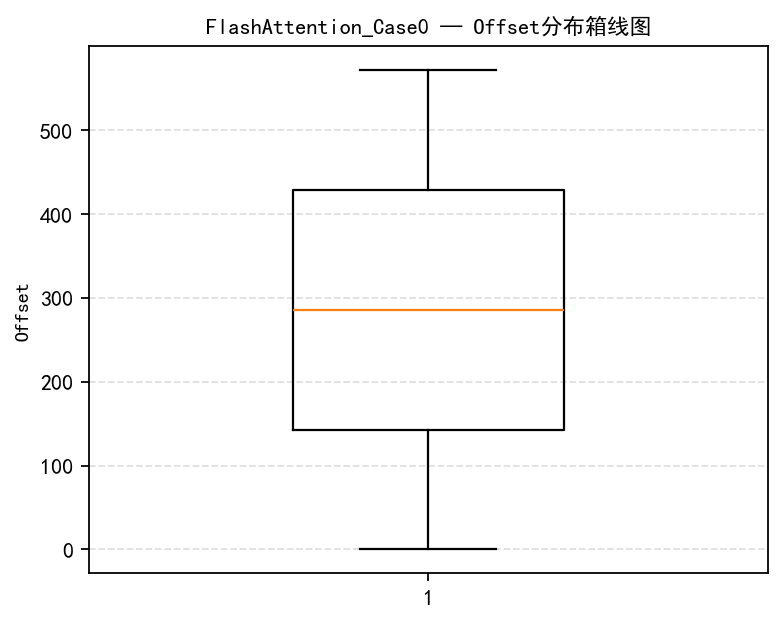

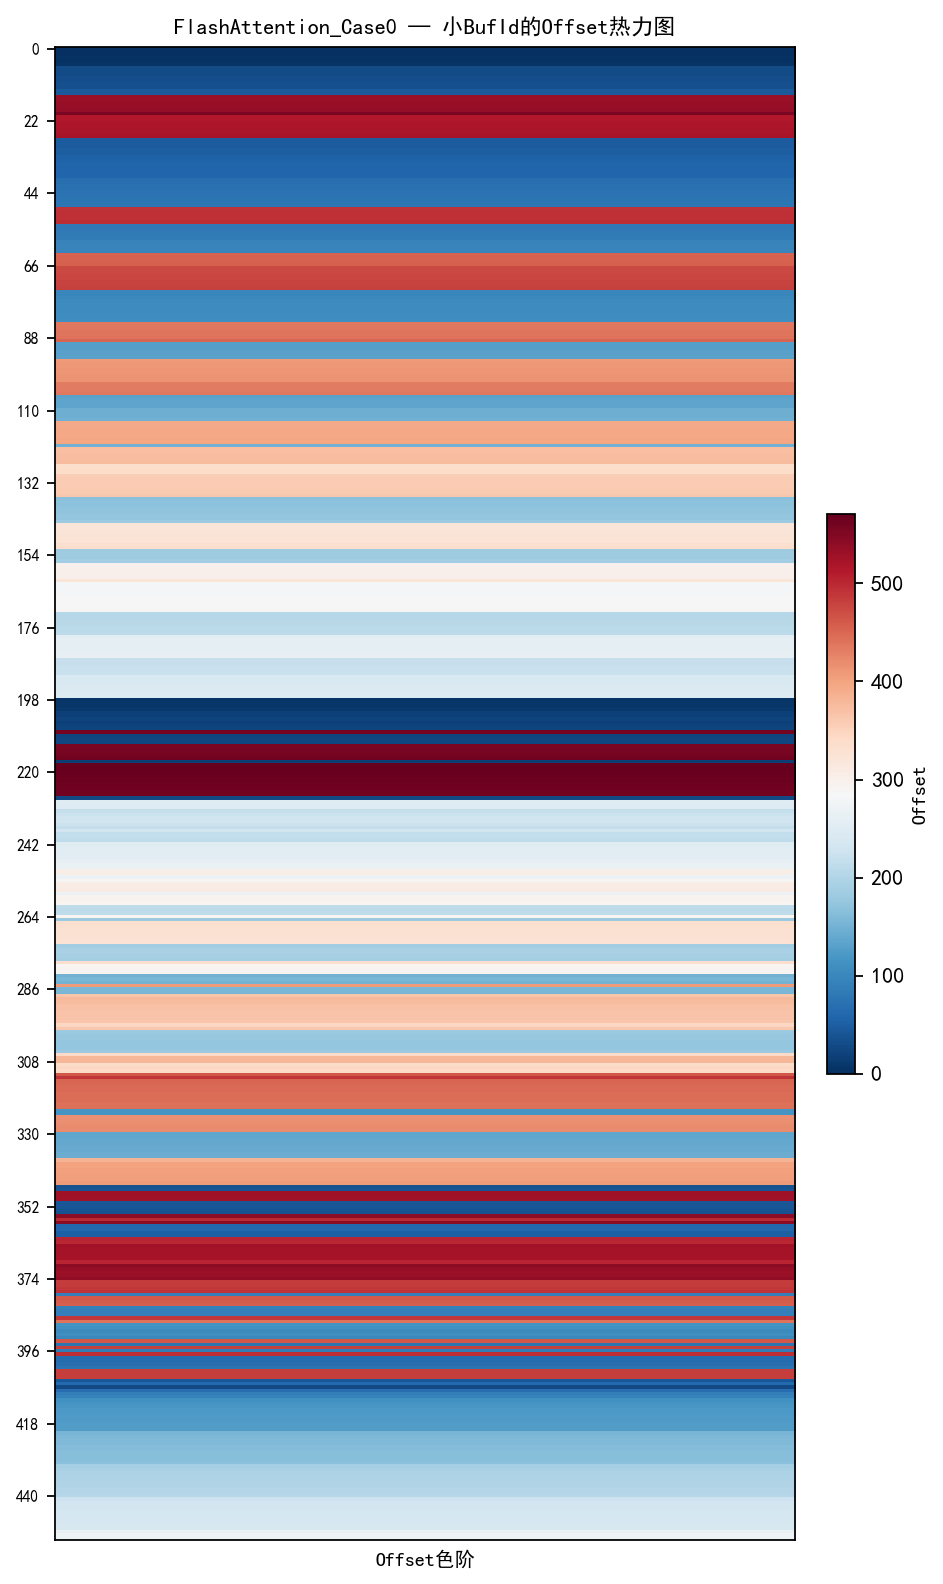

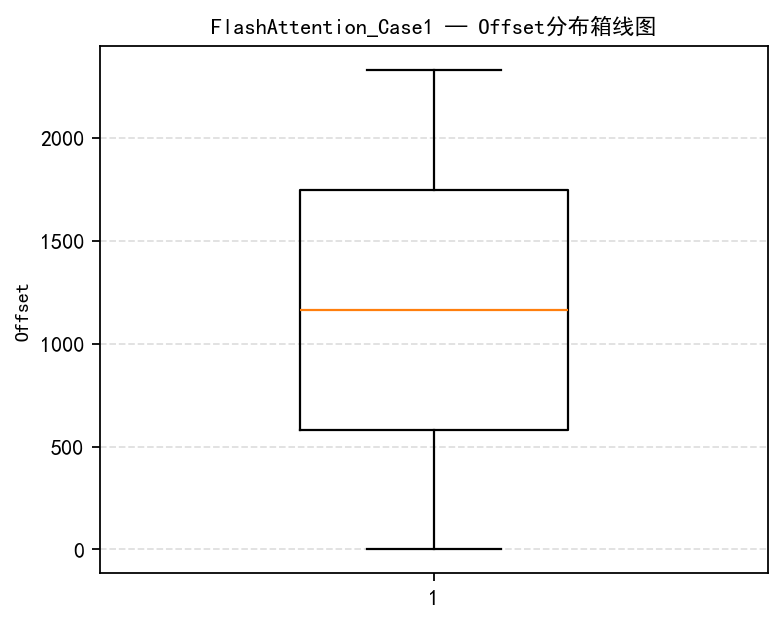

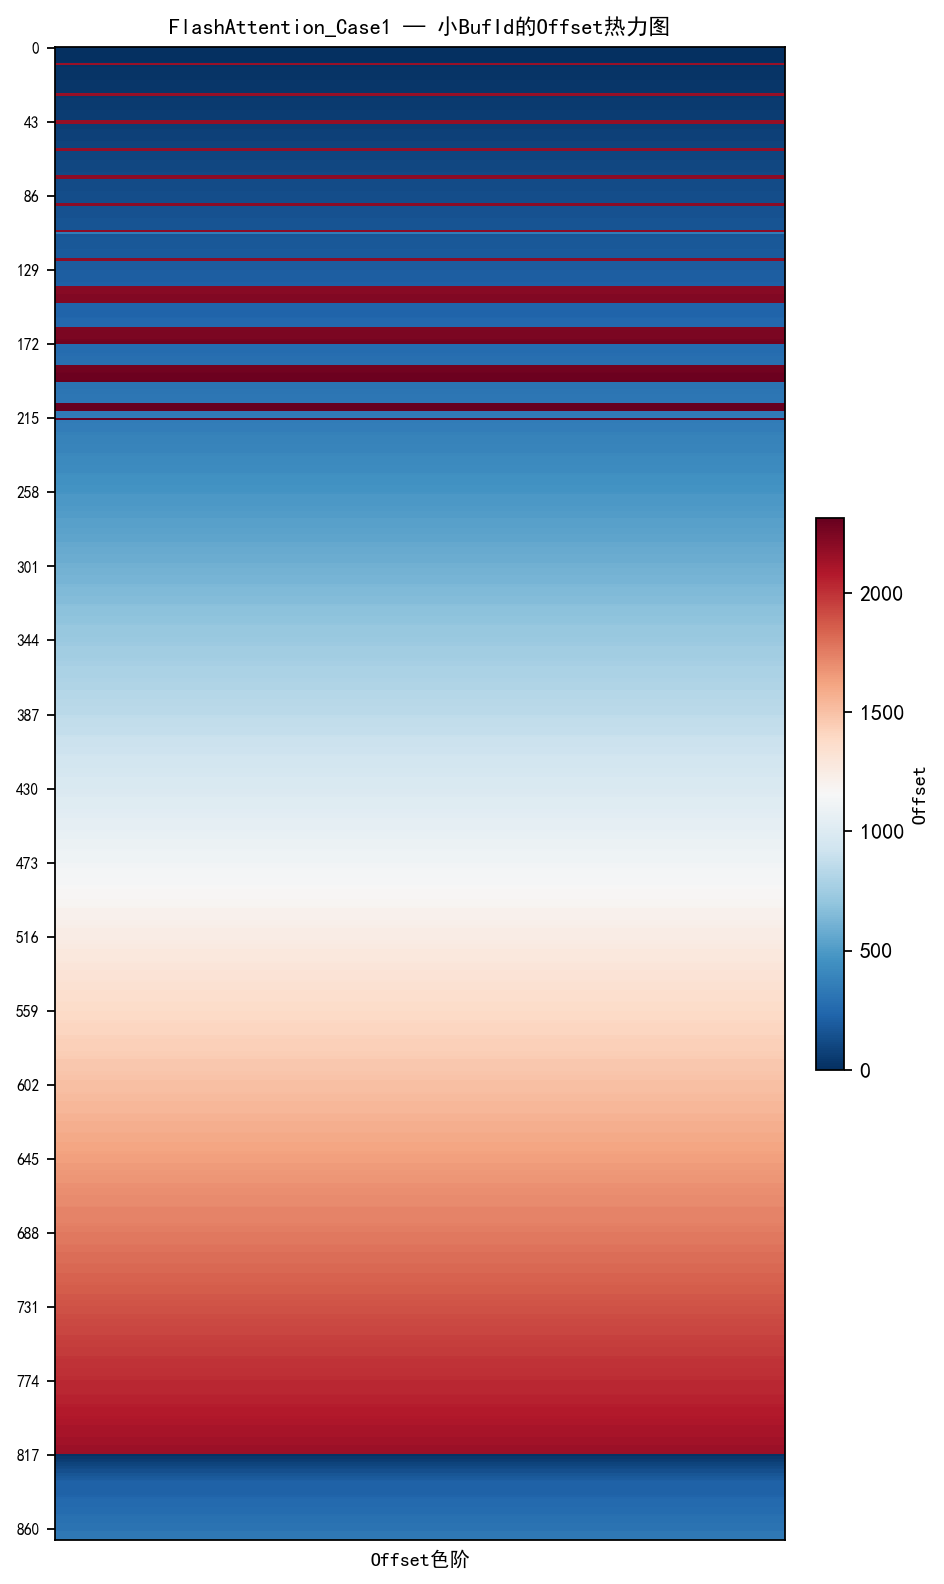

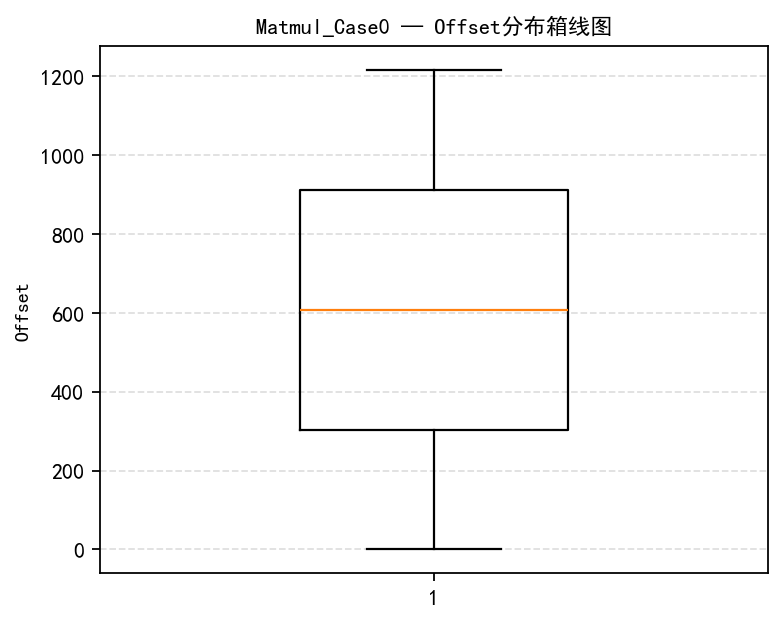

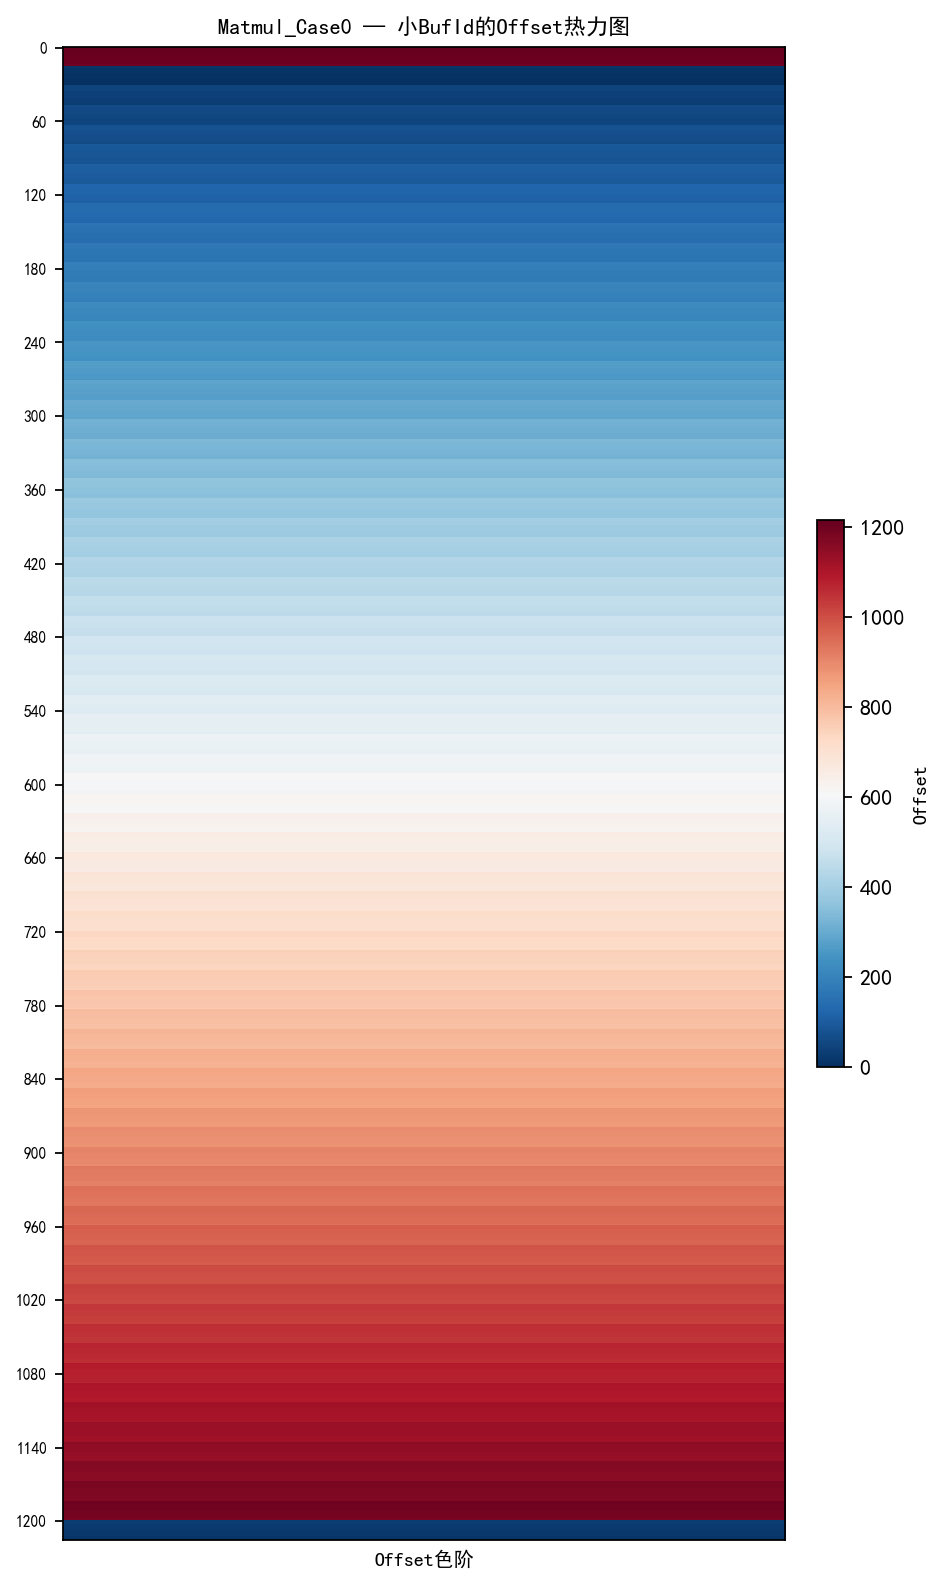

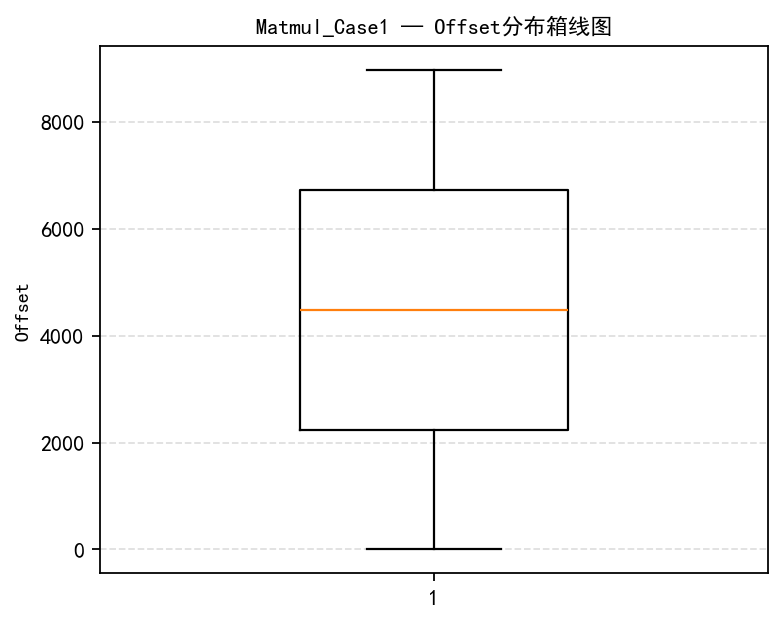

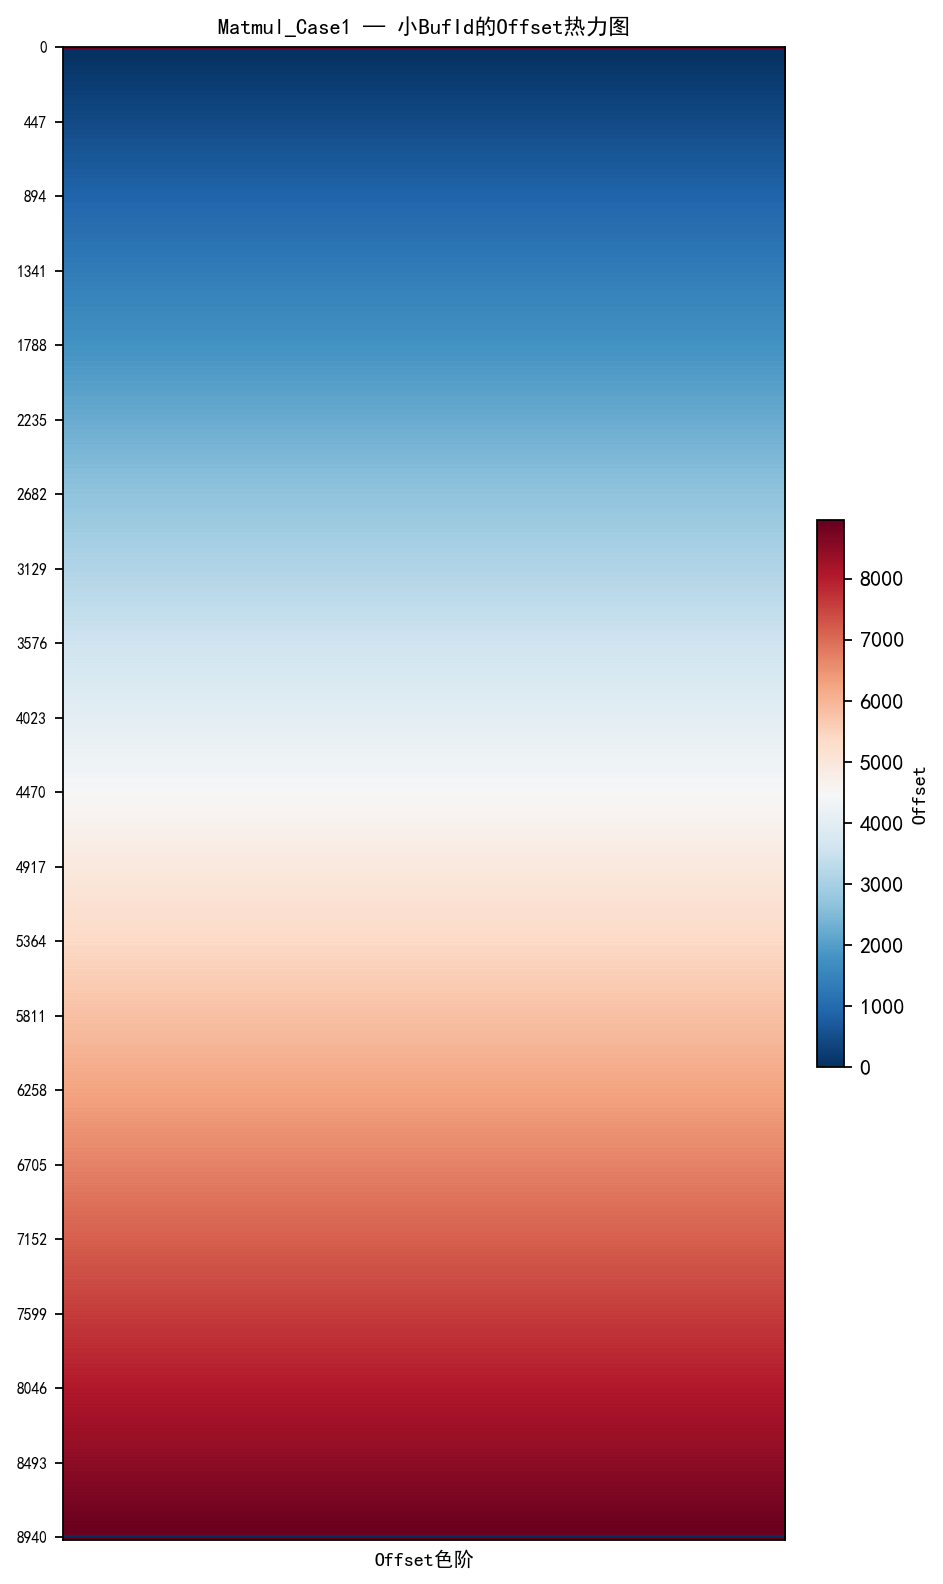

已生成：
 - ./plots\Conv_Case0_offset_boxplot.png
 - ./plots\Conv_Case0_offset_heatmap.png
 - ./plots\Conv_Case1_offset_boxplot.png
 - ./plots\Conv_Case1_offset_heatmap.png
 - ./plots\FlashAttention_Case0_offset_boxplot.png
 - ./plots\FlashAttention_Case0_offset_heatmap.png
 - ./plots\FlashAttention_Case1_offset_boxplot.png
 - ./plots\FlashAttention_Case1_offset_heatmap.png
 - ./plots\Matmul_Case0_offset_boxplot.png
 - ./plots\Matmul_Case0_offset_heatmap.png
 - ./plots\Matmul_Case1_offset_boxplot.png
 - ./plots\Matmul_Case1_offset_heatmap.png


In [2]:
import glob, os
from IPython.display import Image, display

base_dir = r"./"     # your Excel content
out_dir  = os.path.join(base_dir, "plots")
os.makedirs(out_dir, exist_ok=True)

all_png = []
for xlsx in glob.glob(os.path.join(base_dir, "*_memory_analysis.xlsx")):
    outs = plot_for_file(xlsx, out_dir)
    all_png.extend(outs)

# 显示
for p in all_png:
    display(Image(filename=p))

print("已生成：")
for p in all_png:
    print(" -", p)
